# **Importing necessary libraries for EDA and building the CNN model for multi-class image classification**

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import load_model
import tensorflow_hub as hub

In [2]:
print(tf.__version__)

2.15.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Dataset_spines

/content/gdrive/MyDrive/Colab Notebooks/Dataset_spines


In [5]:
!ls

filopodia  mushroom  stubby  thin


In [6]:
np.random.seed(101)

## **Working with Validation and training data**

In [7]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset'

/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset


In [8]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset


In [9]:
!ls

MobileNet_spine_categorizer.keras  Spine_Categorizer_InceptionV3.keras	train  val


### **Getting the class names programatically**

In [10]:
import pathlib
data_dir = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/train')


#Create a list of class names from the subdirectory
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['filopodia' 'mushroom' 'stubby' 'thin']


## **Visualizing the Images**

In [11]:
## Using helper function to view random images

import random

def view_random_image(target_dir, target_class):

  #Setting up the target directory(we'll view images from here)
  target_folder = target_dir + target_class

  # Getting a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Reading image and displaying using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img, cmap='gray')
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}') # Showing the size of image

  return img

['Mushroom 92.jpg']
Image shape: (250, 250)


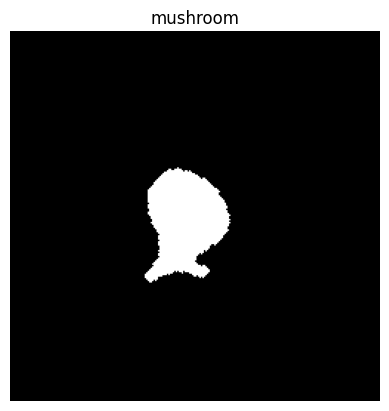

In [12]:
# Viewing random Mushroom spine image

target_directory_for_images = '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/train/'
target_class_of_image = 'mushroom'

img_class2 = view_random_image(target_dir = target_directory_for_images,
                        target_class = target_class_of_image)

['Stubby 98.jpg']
Image shape: (250, 250)


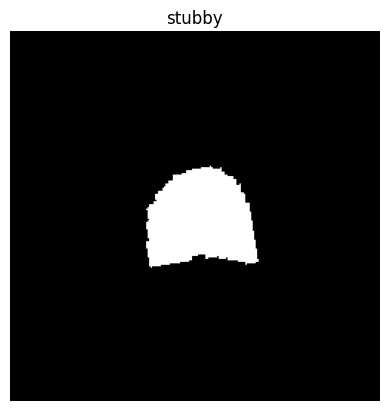

In [13]:
# Viewing random Stubby spine image

target_directory_for_images = '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/train/'
target_class_of_image = 'stubby'

img_class3 = view_random_image(target_dir = target_directory_for_images,
                        target_class = target_class_of_image)

['filopodiaimage005.png']
Image shape: (285, 295, 3)


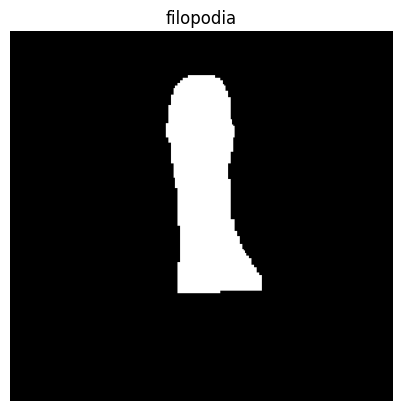

In [14]:
# Viewing random Filopodia spine image

target_directory_for_images = '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/train/'
target_class_of_image = 'filopodia'

img_class1 = view_random_image(target_dir = target_directory_for_images,
                        target_class = target_class_of_image)

['Thin 19.jpg']
Image shape: (692, 1177, 3)


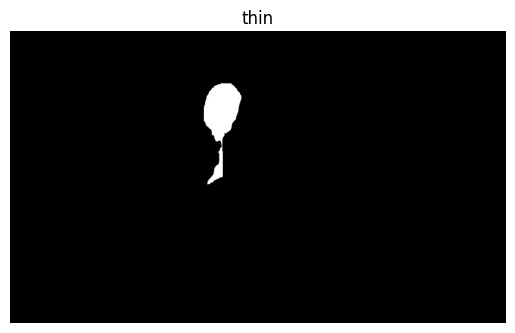

In [15]:
# Viewing random Thin spine image

target_directory_for_images = '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/train/'
target_class_of_image = 'thin'

img_class4 = view_random_image(target_dir = target_directory_for_images,
                        target_class = target_class_of_image)

In [16]:
img_class1.shape, img_class2.shape, img_class3.shape, img_class4.shape

((285, 295, 3), (250, 250), (250, 250), (692, 1177, 3))

### **Normalizing our data according to the mean dimension of the images present in the training folder**

In [17]:
## Setting training, validation and testing directories

train_path = '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/train/'
val_path = '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/val/'

In [18]:
class_names,class_names[0], type(class_names[0])

(array(['filopodia', 'mushroom', 'stubby', 'thin'], dtype='<U9'),
 'filopodia',
 numpy.str_)

## **Augmenting images and compiling the model**
#### ***Changing image dimension to (224,224) for matching MobileNetV2 expected input dimesnions***

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
image_size = (224,224)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10, # Shift the pic width by a max of 5%
    height_shift_range=0.10, # Shift the pic height by a max of 5%
    rescale=1/255, # Rescale the image by normalzing it.
    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1, # Zoom in by 10% max
    horizontal_flip=True, # Allow horizontal flipping
    fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

validation_gen = datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
)

Found 443 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


#### **Labels for the classes (Which class indicates which index)**

In [21]:
train_gen.class_indices

{'filopodia': 0, 'mushroom': 1, 'stubby': 2, 'thin': 3}

In [22]:
validation_gen.class_indices

{'filopodia': 0, 'mushroom': 1, 'stubby': 2, 'thin': 3}

## **Creating base model from pretrained InceptionV3 instance using TFHub**

In [23]:
inception_v3 ="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"

### ***Build the classification model***

In [25]:
from tensorflow.keras import metrics

In [27]:
## Implementing distributed training with multiple GPUs for faster training

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
  base_model = hub.KerasLayer(inception_v3, input_shape=(224, 224, 3), trainable=False)
  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')  # 4 categories
  ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.CategoricalAccuracy(), metrics.Precision(), metrics.Recall()])


In [28]:
# Summarizing the Model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 23905060 (91.19 MB)
Trainable params: 2102276 (8.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [29]:
## Fitting the model

model_history = model.fit(train_gen, epochs=20, validation_data=validation_gen)

Epoch 1/20
14/14 [==============================] - 274s 19s/step - loss: 1.4885 - categorical_accuracy: 0.6411 - precision: 0.6574 - recall: 0.5847 - val_loss: 0.5178 - val_categorical_accuracy: 0.8036 - val_precision: 0.8165 - val_recall: 0.7946
Epoch 2/20
14/14 [==============================] - 12s 887ms/step - loss: 0.5359 - categorical_accuracy: 0.8600 - precision: 0.8716 - recall: 0.8578 - val_loss: 0.3333 - val_categorical_accuracy: 0.8839 - val_precision: 0.8839 - val_recall: 0.8839
Epoch 3/20
14/14 [==============================] - 9s 683ms/step - loss: 0.3188 - categorical_accuracy: 0.8894 - precision: 0.9032 - recall: 0.8849 - val_loss: 0.1891 - val_categorical_accuracy: 0.9107 - val_precision: 0.9189 - val_recall: 0.9107
Epoch 4/20
14/14 [==============================] - 9s 629ms/step - loss: 0.2437 - categorical_accuracy: 0.9120 - precision: 0.9180 - recall: 0.9097 - val_loss: 0.2379 - val_categorical_accuracy: 0.9107 - val_precision: 0.9189 - val_recall: 0.9107
Epoch 5

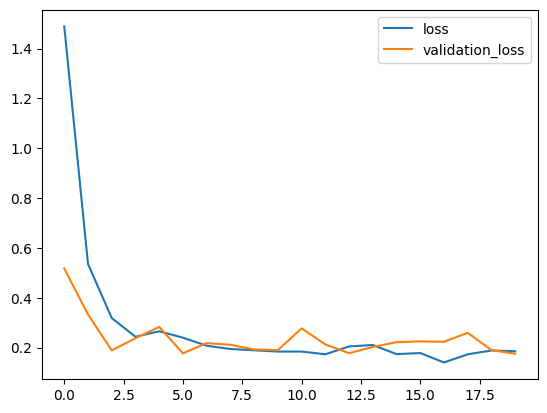

In [32]:
#Plotting loss per iteration

plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'], label = 'validation_loss')
plt.legend()

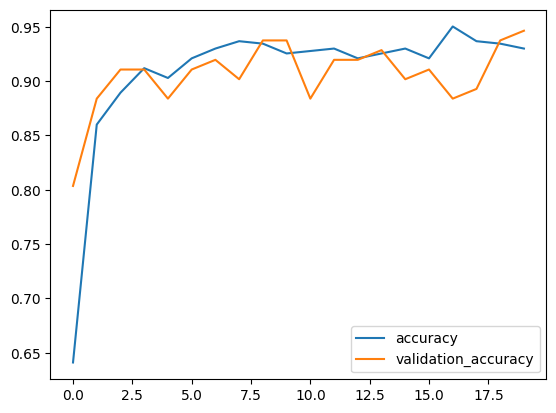

In [34]:
#Plotting accuracy per iteration

plt.plot(model_history.history['categorical_accuracy'],label='accuracy')
plt.plot(model_history.history['val_categorical_accuracy'], label = 'validation_accuracy')
plt.legend()


In [35]:
## Evaluating our model

print(model.evaluate(validation_gen))

4/4 [==============================] - 3s 629ms/step - loss: 0.1710 - categorical_accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554
[0.17100103199481964, 0.9553571343421936, 0.9553571343421936, 0.9553571343421936]


In [49]:
# Get the evaluation results
eval_results = model.evaluate(validation_gen)

# Extract the precision and recall values
precision = eval_results[2]
recall = eval_results[3]

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("F1 Score: ", f1_score)


4/4 [==============================] - 2s 372ms/step - loss: 0.1906 - categorical_accuracy: 0.9464 - precision: 0.9545 - recall: 0.9375
F1 Score:  0.9459459379638289


## **Testing and predicting custom images**

In [36]:
from google.colab import files
from tensorflow.keras.preprocessing import image

In [47]:
plt.figure(figsize=(10, 10))

uploaded=files.upload()


Saving filopodiaimage003.png to filopodiaimage003.png


<Figure size 1000x1000 with 0 Axes>

The shape is (224, 224, 3)
1/1 [==============================] - 0s 119ms/step
The uploaded image of spine belongs to the class THIN


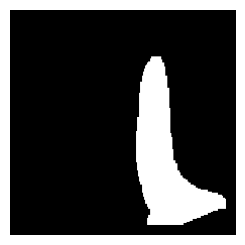

In [48]:
i=1

for fn in uploaded.keys():

  # predicting images

  path='/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/' + fn
  img=tf.keras.utils.load_img(path, color_mode='rgb',target_size=(224, 224))

  plt.subplot(1,2,i)

  plt.imshow(img,cmap='gray',label=fn)
  plt.axis('off')

  i+=1

  x=image.img_to_array(img)
  print(f"The shape is {x.shape}")
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images,batch_size=16)
  #print(classes)

values = classes[0].tolist()
ind = values.index(max(values)) + 1
if(ind==1):
  print('The uploaded image of spine belongs to the class FILOPODIA')
elif(ind==2):
  print('The uploaded image of spine belongs to the class MUSHROOM')
elif(ind==3):
  print('The uploaded image of spine belongs to the class STUBBY')
elif(ind==4):
  print('The uploaded image of spine belongs to the class THIN')

In [ ]:
model.save(filepath="/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/Spine_Categorizer_InceptionV3.h5", overwrite=True, save_format="h5")
print('Model Saved')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved


In [ ]:
model.save(filepath="/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/InceptionV3_spine_categorizer.keras", overwrite=True, save_format="keras")
print('Model Saved')